## Denoise Validation


In [12]:
#! lamin init --storage ./lamin-intro --schema bionty 

import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
import numpy as np
import anndata as ad

from scprint.tasks import Denoiser, withknn
from scdataloader.utils import downsample_profile
from scipy.stats import spearmanr
from anndata import AnnData
%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
prostate_combined = sc.read_h5ad("../data/prostate_combined_o2uniqsx.h5ad")

In [7]:
# model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
# '../../data/main/gene_embeddings.parquet')
model = scPrint.load_from_checkpoint(
#    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
    '../../data/temp/last.ckpt',
    precpt_gene_emb=None,
    transformer="normal")

# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
# ../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt
# post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

RuntimeError caught: scPrint is not attached to a `Trainer`.


In [ ]:
#'/pasteur/appa/scratch/jkalfon/scprint/.lamindb/R4ZHoQegxXdSFNFY5LGe.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SHV11AEetZOms4Wh7Ehb.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/V6DPJx8rP3wWRQ43LMHb.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/Gz5G2ETTEuuRDgwm7brA.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/YyBdEsN89p2aF4xJY1CW.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SO5yBTUDBgkAmz0QbG8K.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/r4iCehg3Tw5IbCLiCIbl.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SqvXr3i3PGXM8toXzUf9.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/REIyQZE6OMZm1S3W2Dxi.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/rYZ7gs0E0cqPOLONC8ia.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/FcwMDDbAQPNYIjcYNxoc.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/fvU5BAMJrm7vrgDmZM0z.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad'

In [8]:
adata = sc.read_h5ad('../../data/R4ZHoQegxXdSFNFY5LGe.h5ad')
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/R4ZHoQegxXdSFNFY5LGe.h5ad')
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/REIyQZE6OMZm1S3W2Dxi.h5ad')


adata.layers['true'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 12590 × 70116
    obs: 'hash_label', 'hash_cluster', 'n_genes', 'hashed', 'group', 'treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pct_counts_hb', 'batch', 'S_score', 'G2M_score', 'phase', 'leiden', 'lineage', 'type', 'cds', 'donor_region', 'dpt_pseudotime', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'suspension_type', 'BMI', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'outlier', 'mt_outlier', 'cell

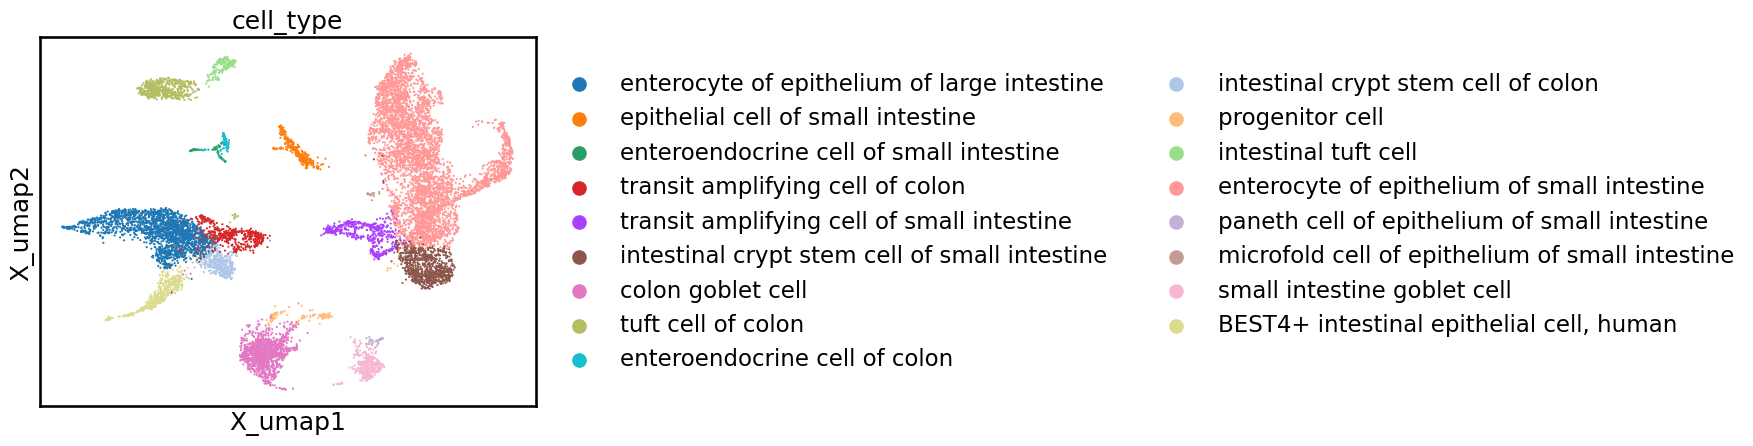

In [10]:
sc.pl.embedding(adata, basis="X_umap", color='cell_type')

In [27]:
adata.obs.cell_type.value_counts()

cell_type
retinal rod cell          31858
OFF-bipolar cell           3892
Mueller cell               3668
amacrine cell              2722
ON-bipolar cell            2611
rod bipolar cell           2319
retinal cone cell          2211
retina horizontal cell     1133
retinal ganglion cell       493
astrocyte                   232
microglial cell             231
Name: count, dtype: int64

In [22]:
adata.obs.drop(columns="is_primary_data", inplace=True)
preprocessor = Preprocessor(do_postp=False)
adata = preprocessor(adata)

Dropping layers:  KeysView(Layers with keys: clean, true)
checking raw counts
removed 0 non primary cells, 12590 renamining
filtered out 0 cells, 12590 renamining
Removed 175 genes.
validating


/Users/jkobject/Documents/code/scPRINT/scDataLoader/scdataloader/preprocess.py:241: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_utils.validate(adata, organism=adata.obs.organism_ontology_term_id[0])


startin QC


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1740f6b00>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/ntest/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/ntest/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x308d6aa70>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/ntest/lib/python3.10/site-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


Seeing 11526 outliers (91.55% of total dataset):
done


In [23]:
adata

View of AnnData object with n_obs × n_vars = 12590 × 70611
    obs: 'hash_label', 'hash_cluster', 'n_genes', 'hashed', 'group', 'treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pct_counts_hb', 'batch', 'S_score', 'G2M_score', 'phase', 'leiden', 'lineage', 'type', 'cds', 'donor_region', 'dpt_pseudotime', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'organism_ontology_term_id', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'suspension_type', 'BMI', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'outlier', 'mt_outlier', 'cell_culture'
 

## regular denoise

In [25]:
model.attn_bias = "none"# = "log"

In [27]:
denoise = Denoiser(
    model,
    batch_size=5,
    max_len=2000,
    plot_corr_size=10_000,
    doplot=False,
    num_workers=1,
    predict_depth_mult=10,
    downsample = 0.7,
    how="most var",
    dtype=torch.bfloat16,
)
metrics, idx, genes, expr = denoise(adata)
metrics

No module named 'triton'
FlashAttention is not installed, not using it..
2000


  0%|          | 0/2000 [00:00<?, ?it/s]

💡 connected lamindb: jkobject/test-public-ontologies


  0%|          | 2/2000 [01:56<32:13:23, 58.06s/it]


KeyboardInterrupt: 

# aggregate with KNN

In [182]:
subadata = AnnData(X=expr.cpu().numpy(), obs=adata.obs.iloc[idx], var=adata.var.loc[genes])

In [185]:
nadata = withknn(subadata, seed=42, k=10)

Performing kNN-smoothing v2.1 with k=10, d=10, and dither=0.030...
Step 1/4: Smooth using k=2
Step 1/4: Smooth using k=2
	PCA took 0.6 s.
	The fraction of variance explained by the top 10 PCs is 57.9 %.
	Calculating pair-wise distance matrix took 0.9 s.
	Calculating the smoothed expression matrix took 6.4 s.
Step 2/4: Smooth using k=4
	PCA took 0.6 s.
	The fraction of variance explained by the top 10 PCs is 72.2 %.
	Calculating pair-wise distance matrix took 0.8 s.
	Calculating the smoothed expression matrix took 6.4 s.
Step 3/4: Smooth using k=8
	PCA took 0.5 s.
	The fraction of variance explained by the top 10 PCs is 81.9 %.
	Calculating pair-wise distance matrix took 0.9 s.
	Calculating the smoothed expression matrix took 6.7 s.
Step 4/4: Smooth using k=10
	PCA took 0.7 s.
	The fraction of variance explained by the top 10 PCs is 88.0 %.
	Calculating pair-wise distance matrix took 0.8 s.
	Calculating the smoothed expression matrix took 6.5 s.
kNN-smoothing finished in 32.7 s.


In [186]:
reco = nadata.layers['denoised']
true = adata.X[idx][:, adata.var.index.isin(genes)].toarray()
noisy = np.loadtxt("collator_output.txt")
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.137829846030993,
 'reco2full': 0.3709222773794356,
 'noisy2full': 0.3458865169667319}

# on random expr

In [ ]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=2200,
    plot_corr_size=5_000,
    doplot=False,
    predict_depth_mult=10,
    downsample = 0.7,
    how="random expr"
)
metrics, idx, genes, expr = denoise(adata)
metrics

100%|██████████| 125/125 [00:45<00:00,  2.72it/s]


{'reco2noisy': 0.7151437850641974,
 'reco2full': 0.3239858026438798,
 'noisy2full': 0.1896732525309344}

## with MAGIC

In [28]:
genes = torch.load('../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=5000, span=0.99)

In [29]:
random_indices = np.random.choice(
    adata.shape[0], size=10_000, replace=False
)
subadata = adata[random_indices, adata.var.index.isin(genes) & adata.var.highly_variable].copy()
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)


In [164]:
denoised_adata = sc.external.pp.magic(subadata.copy(), copy=True, n_jobs=10, solver='approximate', verbose=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):


Calculating MAGIC...


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(


  Running MAGIC on 10000 cells and 3215 genes.


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):


  Calculating graph and diffusion operator...


    Calculating PCA...
    Calculated PCA in 3.88 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.74 seconds.
    Calculating affinities...
    Calculated affinities in 4.80 seconds.
  Calculated graph and diffusion operator in 13.47 seconds.


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("imputation"):


  Calculating imputation...
  Calculated imputation in 0.11 seconds.
  Calculated imputation in 0.11 seconds.
Calculated MAGIC in 14.12 seconds.


In [165]:
reco = denoised_adata.X
true = subadata.layers['true'].toarray()
noisy = subadata.X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.2332537420283647,
 'reco2full': 0.5902201434290297,
 'noisy2full': 0.36316565975829096}

## with MAGIC rare cells

In [30]:
ct = "microglial cell"
subadata
#microglial cell, microfold cell of epithelium of small intestine, mesangial cell, pericyte

AnnData object with n_obs × n_vars = 10000 × 3107
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'descr

In [169]:
reco = denoised_adata[subadata.obs.cell_type==ct].X
true = subadata[subadata.obs.cell_type==ct].layers['true'].toarray()
noisy = subadata[subadata.obs.cell_type==ct].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.16739547347403197,
 'reco2full': 0.40762284286749056,
 'noisy2full': 0.3610326755364074}

## same, with KNN

In [31]:
nadata = withknn(subadata, seed=42, k=10)

Performing kNN-smoothing v2.1 with k=10, d=10, and dither=0.030...

Step 1/4: Smooth using k=2
	PCA took 0.5 s.
	The fraction of variance explained by the top 10 PCs is 25.8 %.
	Calculating pair-wise distance matrix took 1.6 s.
	Calculating the smoothed expression matrix took 6.2 s.
Step 2/4: Smooth using k=4
	PCA took 0.4 s.
	The fraction of variance explained by the top 10 PCs is 35.0 %.
	Calculating pair-wise distance matrix took 1.5 s.
	Calculating the smoothed expression matrix took 6.2 s.
Step 3/4: Smooth using k=8
	PCA took 0.4 s.
	The fraction of variance explained by the top 10 PCs is 46.9 %.
	Calculating pair-wise distance matrix took 1.5 s.
	Calculating the smoothed expression matrix took 6.3 s.
Step 4/4: Smooth using k=10
	PCA took 0.4 s.
	The fraction of variance explained by the top 10 PCs is 59.5 %.
	Calculating pair-wise distance matrix took 1.5 s.
	Calculating the smoothed expression matrix took 6.3 s.
kNN-smoothing finished in 33.6 s.


In [32]:
reco = nadata.layers['denoised']#.toarray()
true = subadata.layers['true'].toarray()
noisy = subadata.X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.41386242619767566,
 'reco2full': 0.5781715062761915,
 'noisy2full': 0.3685645948380719}

## with KNN rare cells

In [33]:
reco = nadata.layers['denoised'][nadata.obs.cell_type==ct]
true = subadata[subadata.obs.cell_type==ct].layers['true'].toarray()
noisy = subadata[subadata.obs.cell_type==ct].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.44956156837292166,
 'reco2full': 0.5479113692785387,
 'noisy2full': 0.3724976804482466}

## MAGIC Rare cell without support

In [170]:
subadata = adata[adata.obs.cell_type==ct, adata.var.index.isin(genes)]
sc.pp.highly_variable_genes(
    subadata, flavor="seurat_v3", n_top_genes=5000, span=0.99)

In [171]:
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)

In [172]:
denoised_adata = sc.external.pp.magic(subadata[:,subadata.var.highly_variable][:30], knn=5, n_jobs=20, solver='approximate', copy=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):
/home/ml4ig1/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 100 dimensions on data with min(n_samples, n_features) = 30
  warnings.warn(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_ta

In [173]:
reco = denoised_adata.X
true = subadata[subadata.obs.cell_type==ct, subadata.var.highly_variable].layers['true'][:30].toarray()
noisy = subadata[subadata.obs.cell_type==ct, subadata.var.highly_variable][:30].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.3116307487080801,
 'reco2full': 0.4477594810317442,
 'noisy2full': 0.3117786337560895}

## scPRINT rare cells

In [ ]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=5000,
    plot_corr_size=30,
    doplot=False,
    predict_depth_mult=10,
    downsample = 0.7,
    how="most var"
)
metrics, idx, genes, expr = denoise(adata[adata.obs.cell_type==ct])
metrics

5000


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


{'reco2noisy': 0.7122362370625847,
 'reco2full': 0.3170816393649402,
 'noisy2full': 0.20527492811994658}